# Gyroscope DDPG training (udacity library)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
cd drive/My\ Drive/Colab Notebooks/DDPG_uda_v0/

/content/drive/My Drive/Colab Notebooks/DDPG_uda_v0


In [1]:
import gym
from gym import spaces
from gym.utils import seeding
from os import path
from scipy.integrate import solve_ivp
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline



#from vpython import *
from ddpg_agent import Agent

ModuleNotFoundError: No module named 'torch'

## Environment Class and Modules

In [ ]:
class GyroscopeEnv(gym.Env):
    
    
    """
    GyroscopeEnv is a double gimbal control moment gyroscope (DGCMG) with 2 input voltage u1 and u2 
    on the two gimbals, and disk speed assumed constant (parameter w). Simulation is based on the 
    Quanser 3-DOF gyroscope setup.
    
    
    **STATE:**
    The state consists of the angle and angular speed of the outer red gimbal (theta = x1, thetadot = x2),
    the angle and angular speed of the inner blue gimbal (phi = x3, phidot = x4), the difference to the reference
    for tracking on theta and phi (tracking error theta = diff_x1, tracking error phi = diff_x3), and the 
    disk speed (disk speed = w):
    
    state = [x1, x2, x3, x4, diff_x1, diff_x3, w]
    
    **ACTIONS:**
    The actions are the input voltage to create the red and blue gimbal torque (red voltage = u1, blue voltage = u2),
    and are continuous in a range of -10 and 10V:
    
    action = [u1,u2]
    
    """
    
    
    metadata = {
        'render.modes' : ['human', 'rgb_array'],
        'video.frames_per_second' : 30
    }

    def __init__(self, dt):
        
        # Inertias in Kg*m2
        self.Jbx1 = 0.0019
        self.Jbx2 = 0.0008
        self.Jbx3 = 0.0012
        self.Jrx1 = 0.0179
        self.Jdx1 = 0.0028
        self.Jdx3 = 0.0056
        
        # Combined inertias
        self.J1 = self.Jbx1 - self.Jbx3 + self.Jdx1 - self.Jdx3
        self.J2 = self.Jbx1 + self.Jdx1 + self.Jrx1
        self.J3 = self.Jbx2 + self.Jdx1

        # Motor constants
        self.Kamp = 0.5 # A/V
        self.Ktorque = 0.0704 # Nm/A
        self.eff = 0.86
        self.nRed = 1.5
        self.nBlue = 1
        self.KtotRed = self.Kamp*self.Ktorque*self.eff*self.nRed 
        self.KtotBlue = self.Kamp*self.Ktorque*self.eff*self.nBlue 
        
        # Time step in s
        self.dt = dt
        
        # Action space
        self.maxVoltage = 10 # V
        self.highAct = np.array([self.maxVoltage,self.maxVoltage])
        self.action_space =  spaces.Box(low = -self.highAct, high = self.highAct, dtype=np.float32) 
        
        # Observation space (here it is equal to state space)
        self.maxSpeed = 40 * 2 * np.pi / 60
        self.maxAngle = np.pi
        self.maxdiskSpeed = 300 * 2 * np.pi / 60
        self.highObs = np.array([self.maxAngle,self.maxSpeed,self.maxAngle,self.maxSpeed,self.maxAngle,self.maxAngle,self.maxdiskSpeed])
        self.observation_space = spaces.Box(low = -self.highObs, high = self.highObs, dtype=np.float32)

        # Seed for random number generation
        self.seed()
        
        self.viewer = None

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]
    
    

    def step(self,u):
        x1, x2, x3, x4, x1_ref, x3_ref, w= self.state 
        u1,u2 = u
      
        # Option 1 for reward:
        reward = 0.5*(angle_normalize(x1 - x1_ref)**2 + angle_normalize(x3 - x3_ref)**2) #+ .001*(x2**2) + .001*(x4**2) + .001*(u1**2) + .001*(u2**2)

        # Option 2 for reward:
       
        """if diff_x1**2<0.01 and diff_x3**2<0.01:
            reward = 0
        else:
            reward = 1"""


        results = solve_ivp(fun = dxdt, t_span = (0, self.dt), y0 = [x1,x2,x3,x4], method='RK45', args=(u1,u2,self))
 
        x1 = angle_normalize(results.y[0][-1])
        x2 = np.clip(results.y[1][-1],-self.maxSpeed,self.maxSpeed)
        x3 = angle_normalize(results.y[2][-1])
        x4 = np.clip(results.y[3][-1],-self.maxSpeed,self.maxSpeed)
        
        self.state = np.asarray([x1,x2,x3,x4,x1_ref, x3_ref,w])

        return (self.state, -reward, False, {})

    def reset(self, state = None):
        
        
        # Generate random state (for training) or use given state (for simulation)
        if state is None:
            self.state = self.np_random.uniform(low=-self.highObs, high=self.highObs)
        else:
            self.state = state
            
        return self.state


    def render(self, mode='human'):
        return None
    
    def close(self):
        if self.viewer:
            self.viewer.close()
            self.viewer = None
            
def dxdt(t, x, u1, u2, gyro):
        
        # Rewrite constants shorter
        J1 = gyro.J1
        J2 = gyro.J2
        J3 = gyro.J3
        Jdx3 = gyro.Jdx3
        KtotRed = gyro.KtotRed
        KtotBlue = gyro.KtotBlue
        w = x[-1]

        # Convert input voltage to input torque
        u1,u2 = KtotRed*u1, KtotBlue*u2
        
        # Equations of motion 
        dx_dt = [0, 0, 0, 0]
        dx_dt[0] = x[1]
        dx_dt[1] = (u1+J1*np.sin(2*x[2])*x[1]*x[3]-Jdx3*np.cos(x[2])*x[3]*w)/(J2 + J1*np.power(np.sin(x[2]),2))
        dx_dt[2] = x[3]
        dx_dt[3] = (u2 - J1*np.cos(x[2])*np.sin(x[2])*np.power(x[1],2)+Jdx3*np.cos(x[2])*x[1]*w)/J3
        return dx_dt
    
def angle_normalize(x):
        return (((x+np.pi) % (2*np.pi)) - np.pi) # To keep the angles between -pi and pi


## DDPG run

In [ ]:
def ddpg(n_episodes=5000, max_t=250, print_every=100):
    scores_deque = deque(maxlen=print_every)
    scores = []
    for i_episode in range(1, n_episodes+1):
        state = env.reset(None)
        agent.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_deque.append(score)
        scores.append(score)
        print('\rEpisode {}\tScore: {:.2f}'.format(i_episode, score), end="")
        torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
        torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
        torch.save(agent.actor_optimizer.state_dict(), 'checkpoint_actor_opt.pth')
        torch.save(agent.critic_optimizer.state_dict(), 'checkpoint_critic_opt.pth')
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            
    return scores


## Training

In [ ]:
# Creat environment
dt = 0.05
env = GyroscopeEnv(dt)
env.seed(2)

# Create agent
agent = Agent(state_size=7, action_size=2, random_seed=2)

"""# Access previous checkpoint
checkpoint_actor = torch.load('checkpoint_actor.pth')
checkpoint_critic = torch.load('checkpoint_critic.pth')
checkpoint_actor_optimizer = torch.load('checkpoint_actor_opt.pth')
checkpoint_critic_optimizer = torch.load('checkpoint_critic_opt.pth')

# Use previous checkpoint
agent.actor_local.load_state_dict(checkpoint_actor)
agent.critic_local.load_state_dict(checkpoint_critic)
agent.actor_optimizer.load_state_dict(checkpoint_actor_optimizer)
agent.critic_optimizer.load_state_dict(checkpoint_critic_optimizer)"""

scores = ddpg()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode 100	Average Score: -2418.53
Episode 200	Average Score: -1813.93
Episode 300	Average Score: -1814.60
Episode 341	Score: -1640.05

KeyboardInterrupt: ignored

## Test

In [ ]:
# Creat environment
dt = 0.05
env = GyroscopeEnv(dt)
env.seed(2)

# Create agent
agent = Agent(state_size=7, action_size=2, random_seed=2)
agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))

# Test parameters
x1,x2,x3,x4,x1_ref,x3_ref,w = 2,0,0,0,1,1.22,10
state = env.reset(np.array([x1,x2,x3,x4,x1_ref,x3_ref,w]))
val = []
dt = 0.05
time = np.arange(0, 30, dt)
score = 0
for i in range(len(time)):
    val.append(state)
    action = agent.act(state, add_noise=False)
    state, reward, done, _ = env.step(action)
    score += reward
    if done:
        break 

env.close()
print(score)

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


-84.65790332698876


## Plot

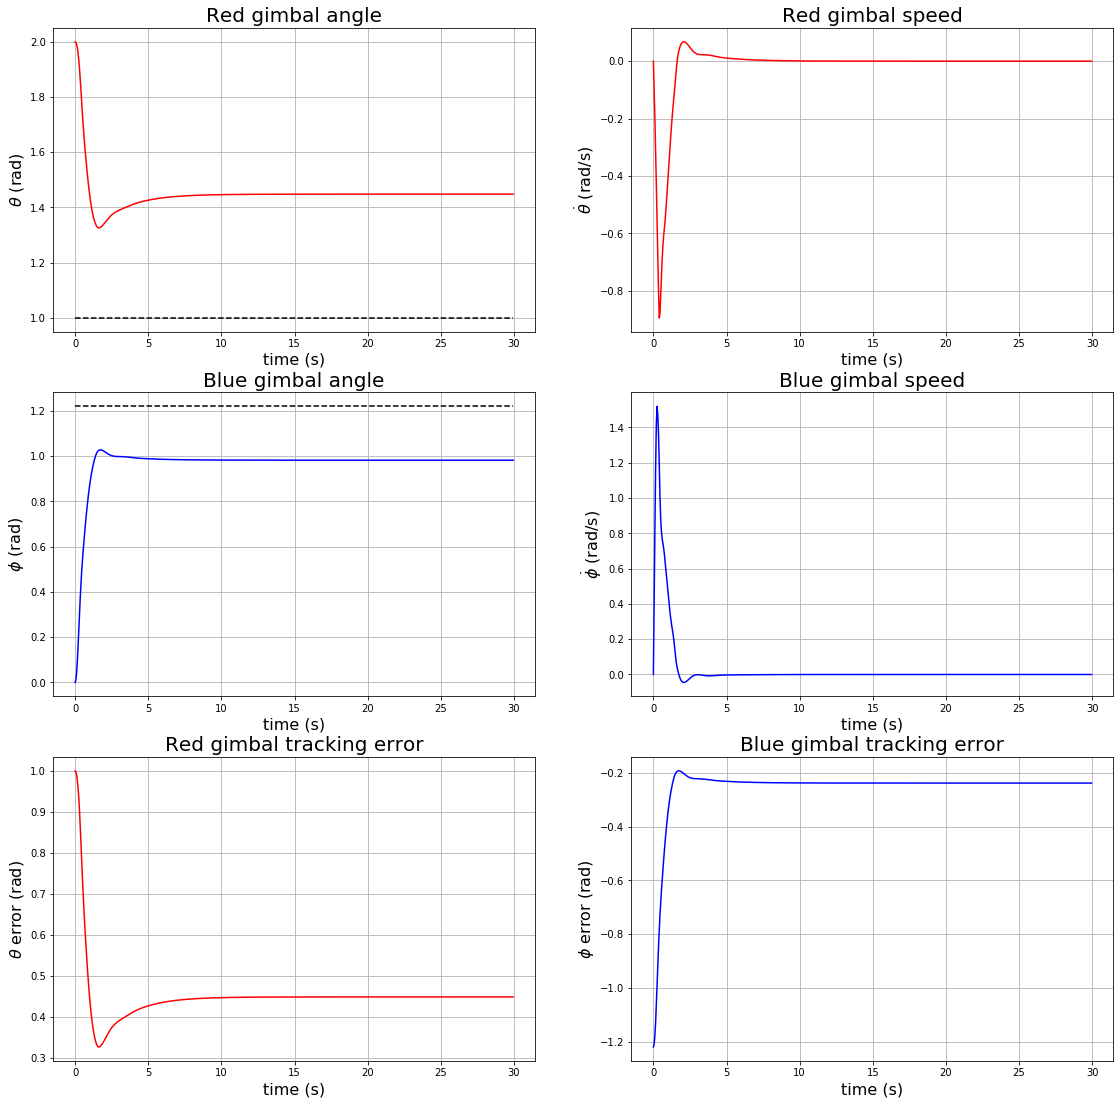

In [ ]:
f, axs = plt.subplots(3,2,figsize=(19,19))
plt.subplot(3,2,1)
plt.title('Red gimbal angle',fontsize=20)
plt.xlabel('time (s)',fontsize=16)
plt.ylabel(r'$\theta$ (rad)',fontsize=16)
plt.grid()
plt.plot(time,[row[0] for row in val],'r-')
plt.plot(time, [row[4] for row in val], color='black', linestyle='dashed')

plt.subplot(3,2,2)
plt.title('Red gimbal speed',fontsize=20)
plt.xlabel('time (s)',fontsize=16)
plt.ylabel(r'$\dot \theta$ (rad/s)',fontsize=16)
plt.grid()
plt.plot(time,[row[1] for row in val],'r-')

plt.subplot(3,2,3)
plt.title('Blue gimbal angle',fontsize=20)
plt.xlabel('time (s)',fontsize=16)
plt.ylabel(r'$\phi$ (rad)',fontsize=16)
plt.grid()
plt.plot(time,[row[2] for row in val],'b-')
plt.plot(time, [row[5] for row in val], color='black', linestyle='dashed')

plt.subplot(3,2,4)
plt.title('Blue gimbal speed',fontsize=20)
plt.xlabel('time (s)',fontsize=16)
plt.ylabel(r'$\dot \phi$ (rad/s)',fontsize=16)
plt.grid()
plt.plot(time,[row[3] for row in val],'b-')

plt.subplot(3,2,5)
plt.title('Red gimbal tracking error',fontsize=20)
plt.xlabel('time (s)',fontsize=16)
plt.ylabel(r'$\theta$ error (rad)',fontsize=16)
plt.grid()
plt.plot(time,[(row[0]- row[4]) for row in val],'r-')

plt.subplot(3,2,6)
plt.title('Blue gimbal tracking error',fontsize=20)
plt.xlabel('time (s)',fontsize=16)
plt.ylabel(r'$\phi$ error (rad)',fontsize=16)
plt.grid()
plt.plot(time,[(row[2]- row[5]) for row in val],'b-')

plt.show()

## 3D rendering

In [ ]:
# Scene
scene = canvas(background=color.white) 

# Objects
redGimbal = ring(pos=vector(0,0,0), axis=vector(0,0,1), radius=2, thickness=0.2,color=vector(0.9,0,0))
blueGimbal1 = cylinder(pos=vector(0,0,0), axis=vector(0,2,0), radius=0.3,color=color.blue)
blueGimbal2 = cylinder(pos=vector(0,0,0), axis=vector(0,-2,0), radius=0.3,color=color.blue)
disk1 = cylinder(pos=vector(0,0,0), axis=vector(0,0,0.15), radius=1.3,color=color.yellow)
disk2 = cylinder(pos=vector(0,0,0), axis=vector(0,0,-0.15), radius=1.3,color=color.yellow)
baseR = extrusion(path=[vec(0,0,0), vec(0.7,0,0)],shape=[ shapes.circle(radius=0.5) ], pos=vec(2,0,0), color=color.black)
baseL = extrusion(path=[vec(-0.7,0,0), vec(0,0,0)],shape=[ shapes.circle(radius=0.5) ], pos=vec(-2,0,0), color=color.black)

t = 0
dt = 0.01
loops = 0
ctime = 0
start = clock()
N = 200

# 6.4/100
for k in range(len(time)):
    rate(N)
    ct = clock()
    theta = val[k][0]
    phi = val[k][2]
    redGimbal.axis = vector(0,-sin(theta), cos(theta))
    blueGimbal1.axis = 2*vector(0,cos(theta), sin(theta))
    blueGimbal2.axis = -2*vector(0,cos(theta), sin(theta))
    disk1.axis = 0.15*vector(-sin(phi),-sin(theta)*cos(phi),cos(theta)*cos(phi))
    disk2.axis = -0.15*vector(-sin(phi),-sin(theta)*cos(phi),cos(theta)*cos(phi))
    ctime += clock()-ct
    loops += 1